In [1]:
import random

from deap import base
from deap import creator
from deap import tools

C:\Users\gwgwa\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [2]:
# Problem parameter
n = 20

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("IndividualQueen", list, fitness=creator.FitnessMin)

In [3]:
#Since there is only one queen per line, 
#individual are represented by a permutation
toolbox_q = base.Toolbox()
toolbox_q.register("permutation", random.sample, range(n), n)

#Structure initializers
#An individual is a list that represents the position of each queen.
#Only the line is stored, the column is the index of the number in the list.
toolbox_q.register("individual", tools.initIterate, creator.IndividualQueen, toolbox_q.permutation)
toolbox_q.register("population", tools.initRepeat, list, toolbox_q.individual)

In [4]:
def evalNQueens(individual):
    size = len(individual)
    #Count the number of conflicts with other queens.
    #The conflicts can only be diagonal, count on each diagonal line
    left_diagonal = [0] * (2*size-1)
    right_diagonal = [0] * (2*size-1)
    
    #Sum the number of queens on each diagonal:
    for i in range(size):
        left_diagonal[i+individual[i]] += 1
        right_diagonal[size-1-i+individual[i]] += 1
    
    #Count the number of conflicts on each diagonal
    sum_ = 0
    for i in range(2*size-1):
        if left_diagonal[i] > 1:
            sum_ += left_diagonal[i] - 1
        if right_diagonal[i] > 1:
            sum_ += right_diagonal[i] - 1
    return sum_,

In [5]:
def cxPartialyMatched(ind1, ind2):
    """Executes a partially matched crossover (PMX) on the input individuals.
    The two individuals are modified in place. This crossover expects
    :term:`sequence` individuals of indices, the result for any other type of
    individuals is unpredictable.
    
    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :returns: A tuple of two individuals.
    Moreover, this crossover generates two children by matching
    pairs of values in a certain range of the two parents and swapping the values
    of those indexes. For more details see [Goldberg1985]_.
    This function uses the :func:`~random.randint` function from the python base
    :mod:`random` module.
    
    .. [Goldberg1985] Goldberg and Lingel, "Alleles, loci, and the traveling
       salesman problem", 1985.
    """
    size = min(len(ind1), len(ind2))
    p1, p2 = [0]*size, [0]*size

    # Initialize the position of each indices in the individuals
    for i in range(size):
        p1[ind1[i]] = i
        p2[ind2[i]] = i
    # Choose crossover points
    cxpoint1 = random.randint(0, size)
    cxpoint2 = random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    
    # Apply crossover between cx points
    for i in range(cxpoint1, cxpoint2):
        # Keep track of the selected values
        temp1 = ind1[i]
        temp2 = ind2[i]
        # Swap the matched value
        ind1[i], ind1[p1[temp2]] = temp2, temp1
        ind2[i], ind2[p2[temp1]] = temp1, temp2
        # Position bookkeeping
        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]
    
    return ind1, ind2

In [6]:
def cxTwoPoint(ind1, ind2):
    """Executes a two-point crossover on the input :term:`sequence`
    individuals. The two individuals are modified in place and both keep
    their original length. 
    
    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :returns: A tuple of two individuals.
    This function uses the :func:`~random.randint` function from the Python 
    base :mod:`random` module.
    """
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
   
    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]
        
    return ind1, ind2

In [7]:
def mutShuffleIndexes(individual, indpb):
    """Shuffle the attributes of the input individual and return the mutant.
    The *individual* is expected to be a :term:`sequence`. The *indpb* argument is the
    probability of each attribute to be moved. Usually this mutation is applied on 
    vector of indices.
    
    :param individual: Individual to be mutated.
    :param indpb: Independent probability for each attribute to be exchanged to
                  another position.
    :returns: A tuple of one individual.
    
    This function uses the :func:`~random.random` and :func:`~random.randint`
    functions from the python base :mod:`random` module.
    """
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 2)
            if swap_indx >= i:
                swap_indx += 1
            individual[i], individual[swap_indx] = \
                individual[swap_indx], individual[i]
    
    return individual,

In [8]:
toolbox_q.register("evaluate", evalNQueens)
toolbox_q.register("mate", cxPartialyMatched)
toolbox_q.register("mutate", mutShuffleIndexes, indpb=2.0/n)
toolbox_q.register("select", tools.selTournament, tournsize=3)

In [9]:
pop = toolbox_q.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox_q.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in range(100):
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox_q.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox_q.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox_q.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox_q.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox_q.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 0 --
  Min 3.0
  Max 15.0
  Avg 9.32
  Std 1.8432579851990325
-- Generation 1 --
  Min 4.0
  Max 14.0
  Avg 8.743333333333334
  Std 1.9002075909986458
-- Generation 2 --
  Min 4.0
  Max 15.0
  Avg 8.543333333333333
  Std 2.1774883594535153
-- Generation 3 --
  Min 4.0
  Max 15.0
  Avg 7.96
  Std 2.0228033353080397
-- Generation 4 --
  Min 3.0
  Max 14.0
  Avg 7.96
  Std 2.2446380554557126
-- Generation 5 --
  Min 3.0
  Max 16.0
  Avg 7.71
  Std 2.3942779008850796
-- Generation 6 --
  Min 3.0
  Max 14.0
  Avg 7.213333333333333
  Std 2.2718176765655205
-- Generation 7 --
  Min 3.0
  Max 14.0
  Avg 7.006666666666667
  Std 2.370644544328725
-- Generation 8 --
  Min 3.0
  Max 15.0
  Avg 7.02
  Std 2.6012048490395125
-- Generation 9 --
  Min 3.0
  Max 14.0
  Avg 6.74
  Std 2.55976561427018
-- Generation 10 --
  Min 3.0
  Max 15.0
  Avg 6.57
  Std 2.6929104453484265
-- Generation 11 --
  Min 3.0
  Max 15.0
  Avg 6.176666666666667
  Std 2.691738389137317
-- Generation 12 --
  Min

-- Generation 0 --
  Min 5.0
  Max 17.0
  Avg 9.55
  Std 1.9063490411429536
-- Generation 1 --
  Min 5.0
  Max 14.0
  Avg 8.793333333333333
  Std 2.0389430813264258
-- Generation 2 --
  Min 4.0
  Max 16.0
  Avg 8.236666666666666
  Std 2.174240608171558
-- Generation 3 --
  Min 4.0
  Max 14.0
  Avg 8.03
  Std 2.235121174940339
-- Generation 4 --
  Min 4.0
  Max 14.0
  Avg 7.733333333333333
  Std 2.292499848539921
-- Generation 5 --
  Min 4.0
  Max 19.0
  Avg 7.74
  Std 2.456094460724179
-- Generation 6 --
  Min 4.0
  Max 14.0
  Avg 7.283333333333333
  Std 2.351536140955998
-- Generation 7 --
  Min 4.0
  Max 15.0
  Avg 7.22
  Std 2.430006858700883
-- Generation 8 --
  Min 4.0
  Max 15.0
  Avg 7.42
  Std 2.4297324955640702
-- Generation 9 --
  Min 3.0
  Max 16.0
  Avg 7.163333333333333
  Std 2.622337803479094
-- Generation 10 --
  Min 2.0
  Max 15.0
  Avg 6.79
  Std 2.430205752606144
-- Generation 11 --
  Min 2.0
  Max 15.0
  Avg 6.78
  Std 2.546553226094701
-- Generation 12 --
  Min 2.0


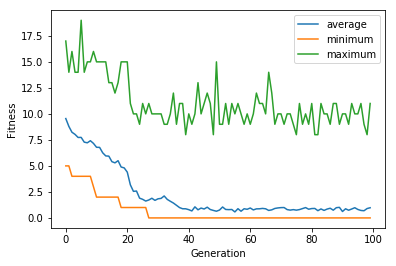

In [10]:
gen = range(100)
avg_list = []
max_list = []
min_list = []

pop = toolbox_q.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox_q.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox_q.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox_q.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox_q.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox_q.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox_q.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(gen, avg_list, label="average")
plt.plot(gen, min_list, label="minimum")
plt.plot(gen, max_list, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()